# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

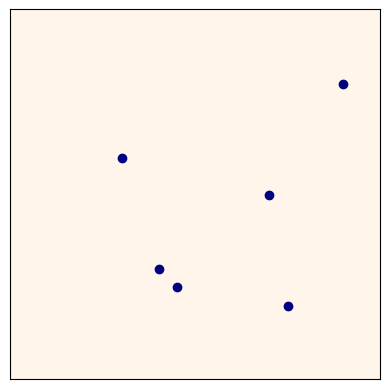

In [2]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

**Answer**:

The Generator network starts with an input layer that takes in random noise. It has multiple hidden layers (3 by default), each with 10 neurons. Each hidden layer performs a linear transformation followed by an ELU activation function. The final output layer transforms the data with a linear step and then uses a Sigmoid function to ensure the outputs are between 0 and 1. This setup helps the network turn random inputs into realistic data points. The weights in the network are initialized using Xavier uniform initialization to improve learning.

In [3]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


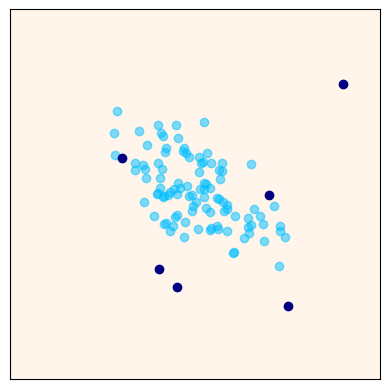

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points

z = torch.randn(b,n_in)
# Input noise z : standard normal with shape (b, n_in)
#x = np.random.normal(0, 1, size=(b, n_in))
### ... ###
x = G(z)
print(x.shape)
# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [5]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

**Answer** :
Changing the `clip_value` affects the range of the discriminator's weights. A smaller `clip_value` can lead to vanishing gradients, while a larger `clip_value` can lead to instability in training.

[0/1000], -0.007124


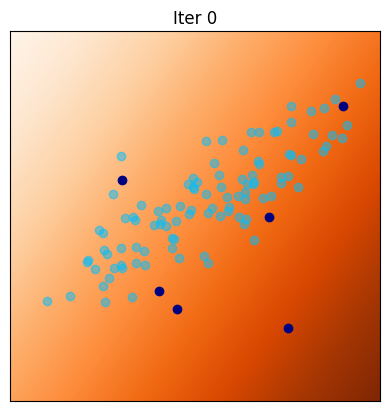

[100/1000], -0.004630


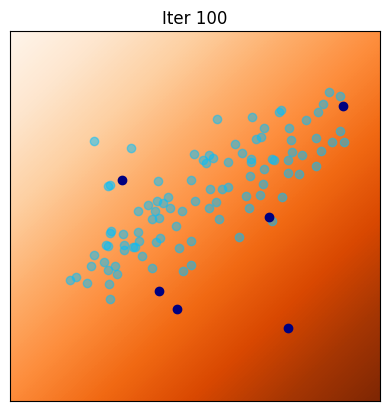

[200/1000], -0.005333


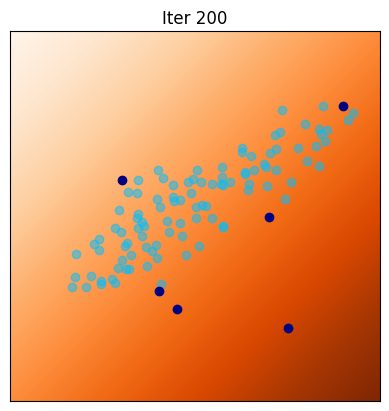

[300/1000], -0.004886


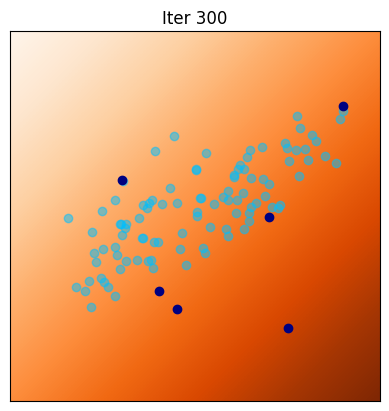

[400/1000], -0.005216


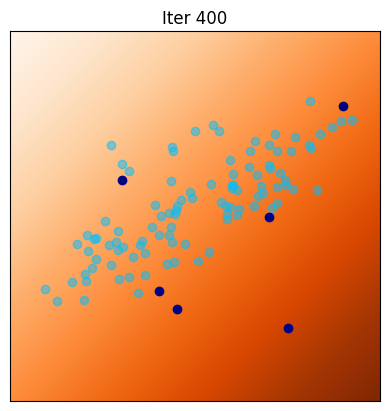

[500/1000], -0.004173


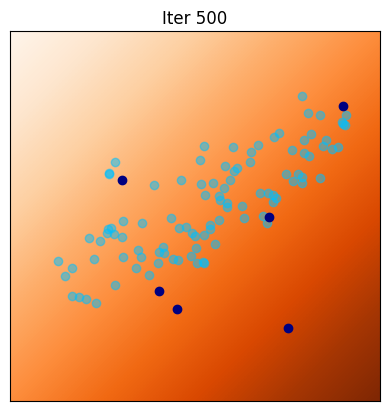

[600/1000], -0.005442


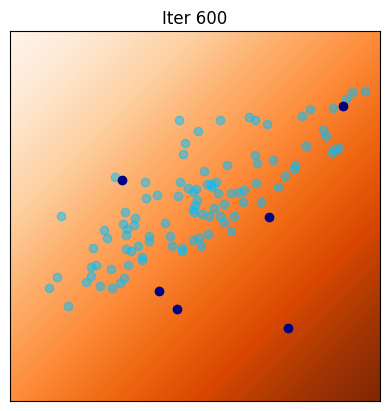

[700/1000], -0.005265


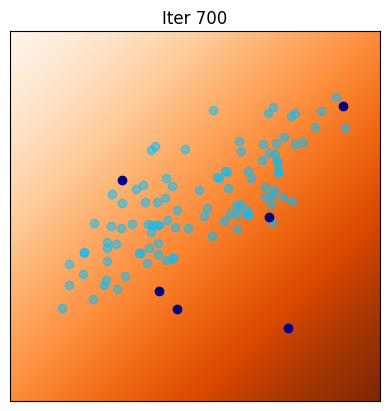

[800/1000], -0.005875


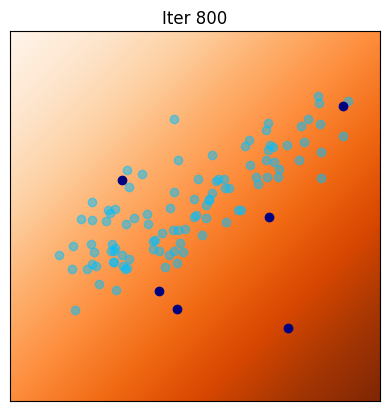

[900/1000], -0.005226


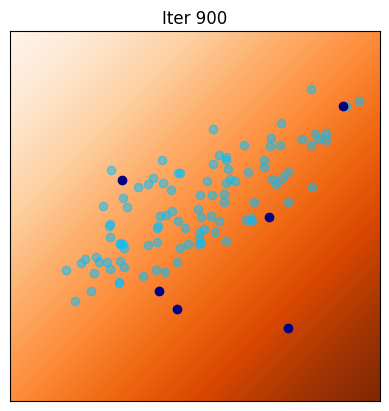

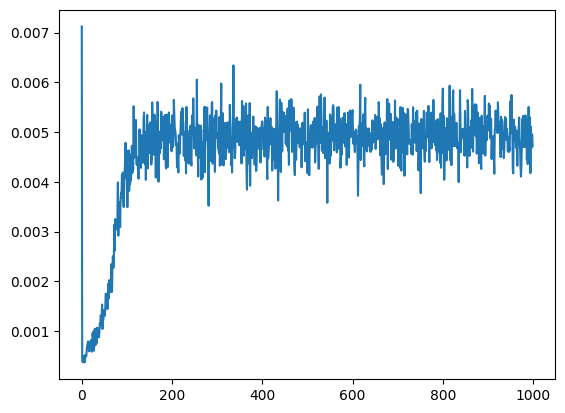

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    ### ... ###
    z = torch.randn(b,n_in)
    x = G(z)

    predict = D.forward(x).detach()
    Dloss = -1 * (torch.mean(D.forward(y)) - torch.mean(predict))
    ### ... ###

    Dloss.backward()

    optimD.step()

    ### ... Weight Clipping ... ###

    for p in D.parameters():
      p.data.clamp_(-clip_value,clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [7]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()


    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)

    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))
    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [8]:
print(lipconstant(D,x,y))

tensor(0.0428, grad_fn=<MeanBackward0>)


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [9]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(0.9163, grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

To get a Lipschitz constant =1 we can change the value of gpw to 30

[0/1000], Dloss=34.1966, Lip(D)=0.0817


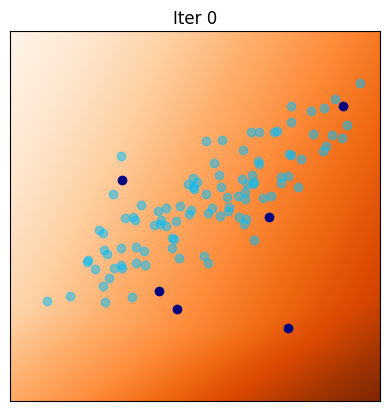

[100/1000], Dloss=0.4824, Lip(D)=0.9991


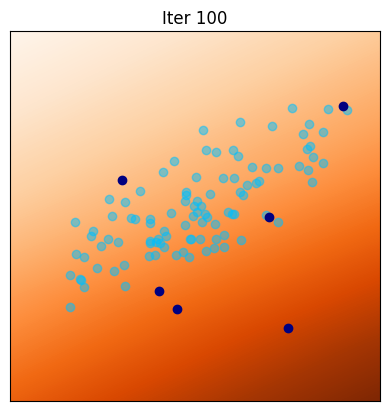

[200/1000], Dloss=0.1602, Lip(D)=0.9818


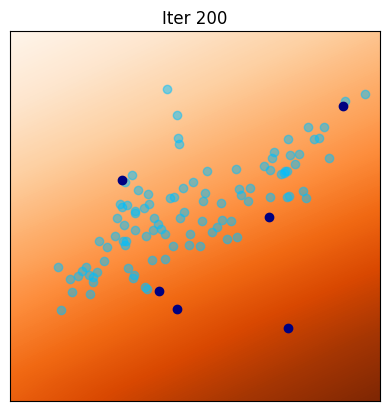

[300/1000], Dloss=-0.0419, Lip(D)=0.9864


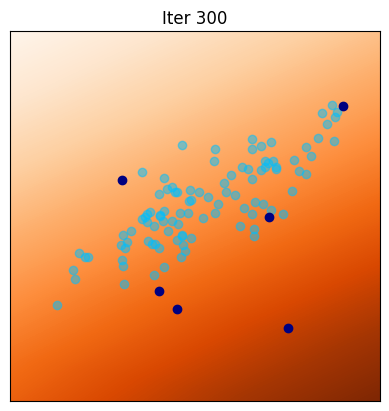

[400/1000], Dloss=-0.0600, Lip(D)=0.9924


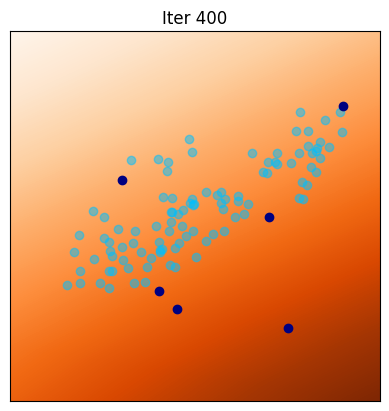

[500/1000], Dloss=-0.1101, Lip(D)=0.9973


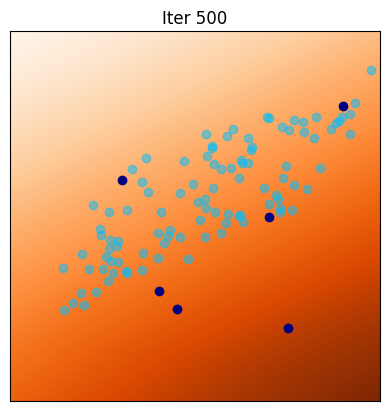

[600/1000], Dloss=-0.1124, Lip(D)=0.9986


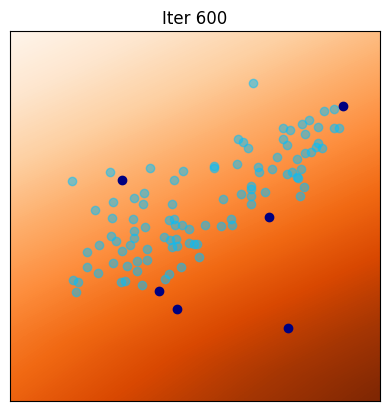

[700/1000], Dloss=-0.1136, Lip(D)=1.0046


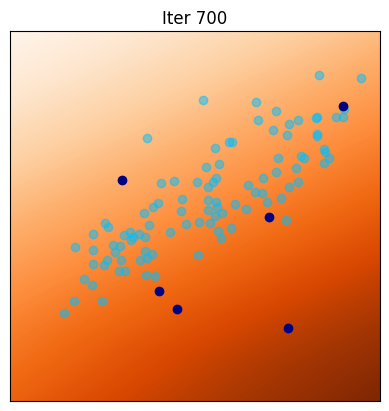

[800/1000], Dloss=-0.1280, Lip(D)=0.9988


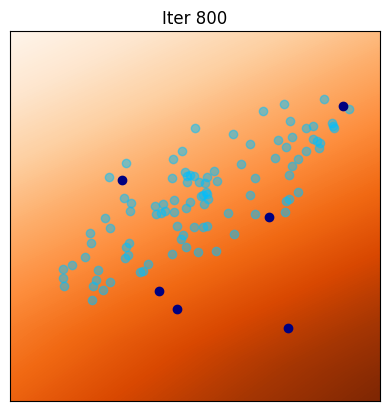

[900/1000], Dloss=-0.1172, Lip(D)=1.0038


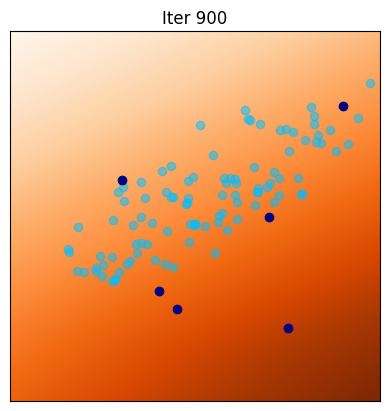

Final estimated Lipschitz constant =  1.000344157218933


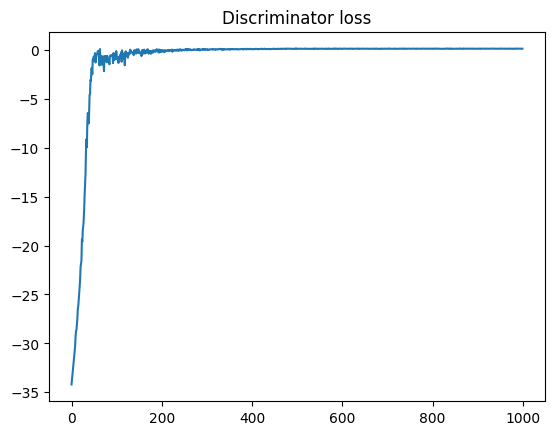

In [10]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = 40       # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    z = torch.randn(b, n_in, device=device)
    x_fake = G(z)
    y_real = y

    D_real = D(y_real).view(-1)
    D_fake = D(x_fake.detach()).view(-1)

    gp = gradient_penalty(D, y_real, x_fake)

    Dloss = -torch.mean(D_real) + torch.mean(D_fake) + gpw * gp

    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1785	Loss_G: -1.7321	Lip(D)=1.6834
[2/100] 	Loss_D: -0.1734	Loss_G: -0.9978	Lip(D)=1.6256
[3/100] 	Loss_D: -0.1691	Loss_G: -2.1016	Lip(D)=1.5141
[4/100] 	Loss_D: -0.1256	Loss_G: -3.4073	Lip(D)=1.3263
[5/100] 	Loss_D: -0.1318	Loss_G: -6.2588	Lip(D)=1.5711


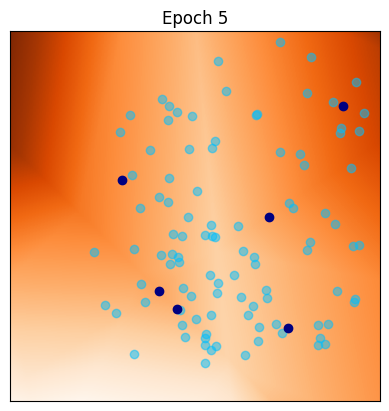

[6/100] 	Loss_D: -0.1087	Loss_G: -10.5444	Lip(D)=1.5239
[7/100] 	Loss_D: -0.1031	Loss_G: -11.8230	Lip(D)=1.5187
[8/100] 	Loss_D: -0.1077	Loss_G: -12.9514	Lip(D)=1.2075
[9/100] 	Loss_D: -0.0583	Loss_G: -12.5288	Lip(D)=1.6373
[10/100] 	Loss_D: -0.0702	Loss_G: -13.1810	Lip(D)=1.1236


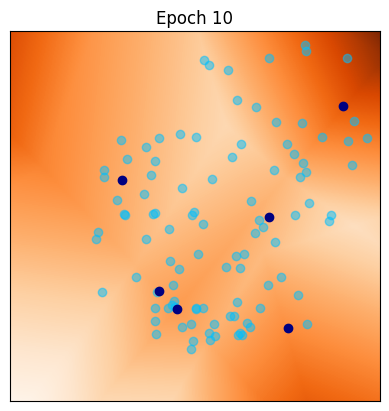

[11/100] 	Loss_D: -0.1003	Loss_G: -14.0047	Lip(D)=1.2576
[12/100] 	Loss_D: -0.1092	Loss_G: -12.8808	Lip(D)=1.4297
[13/100] 	Loss_D: -0.1055	Loss_G: -13.3256	Lip(D)=1.3335
[14/100] 	Loss_D: -0.0674	Loss_G: -14.6130	Lip(D)=1.2281
[15/100] 	Loss_D: -0.1162	Loss_G: -18.2659	Lip(D)=1.2170


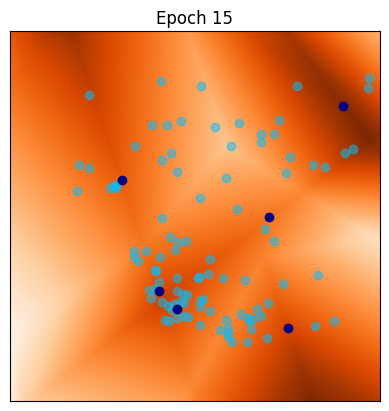

[16/100] 	Loss_D: -0.1241	Loss_G: -22.3917	Lip(D)=1.6685
[17/100] 	Loss_D: -0.0637	Loss_G: -24.9876	Lip(D)=1.3340
[18/100] 	Loss_D: -0.0817	Loss_G: -25.4341	Lip(D)=1.2395
[19/100] 	Loss_D: -0.1210	Loss_G: -24.2385	Lip(D)=1.4331
[20/100] 	Loss_D: -0.0950	Loss_G: -24.9025	Lip(D)=1.3703


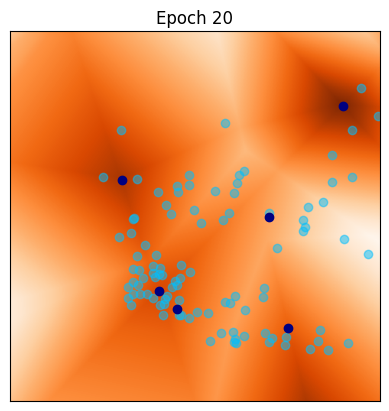

[21/100] 	Loss_D: -0.0756	Loss_G: -24.8698	Lip(D)=1.2628
[22/100] 	Loss_D: -0.1197	Loss_G: -25.9096	Lip(D)=1.4944
[23/100] 	Loss_D: -0.1209	Loss_G: -29.0044	Lip(D)=1.2942
[24/100] 	Loss_D: -0.1281	Loss_G: -30.3571	Lip(D)=1.3189
[25/100] 	Loss_D: -0.1101	Loss_G: -31.4242	Lip(D)=1.1868


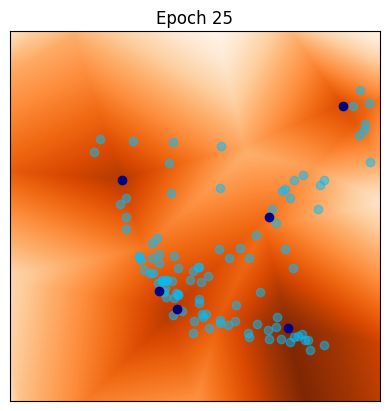

[26/100] 	Loss_D: -0.0675	Loss_G: -32.9344	Lip(D)=1.3369
[27/100] 	Loss_D: -0.0808	Loss_G: -34.8046	Lip(D)=1.4298
[28/100] 	Loss_D: -0.1159	Loss_G: -35.9228	Lip(D)=1.1787
[29/100] 	Loss_D: -0.0969	Loss_G: -36.8739	Lip(D)=1.3047
[30/100] 	Loss_D: -0.0969	Loss_G: -39.5882	Lip(D)=1.3083


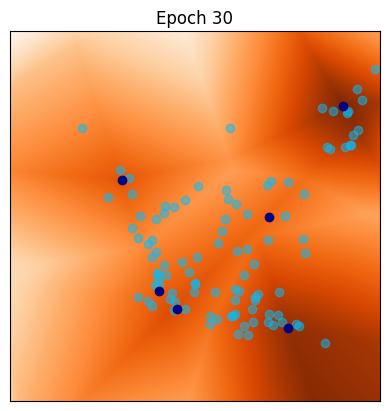

[31/100] 	Loss_D: -0.0594	Loss_G: -41.4664	Lip(D)=1.3809
[32/100] 	Loss_D: -0.1297	Loss_G: -39.6373	Lip(D)=1.4302
[33/100] 	Loss_D: -0.1175	Loss_G: -40.7778	Lip(D)=1.3128
[34/100] 	Loss_D: -0.1005	Loss_G: -40.3050	Lip(D)=1.4012
[35/100] 	Loss_D: -0.1318	Loss_G: -44.2399	Lip(D)=1.3936


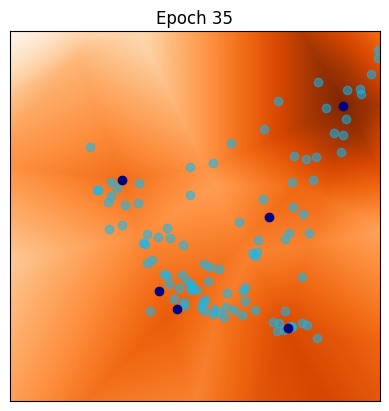

[36/100] 	Loss_D: -0.0545	Loss_G: -45.5858	Lip(D)=1.4792
[37/100] 	Loss_D: -0.0907	Loss_G: -46.7906	Lip(D)=1.4205
[38/100] 	Loss_D: -0.1045	Loss_G: -44.2068	Lip(D)=1.2743
[39/100] 	Loss_D: -0.0967	Loss_G: -45.4252	Lip(D)=1.2902
[40/100] 	Loss_D: -0.0513	Loss_G: -49.5353	Lip(D)=1.4458


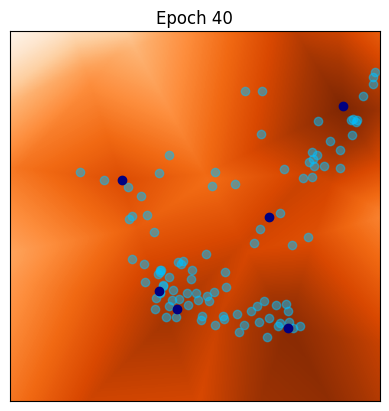

[41/100] 	Loss_D: -0.1072	Loss_G: -47.0678	Lip(D)=1.3571
[42/100] 	Loss_D: -0.0202	Loss_G: -47.8940	Lip(D)=1.4243
[43/100] 	Loss_D: -0.0905	Loss_G: -48.9179	Lip(D)=1.2444
[44/100] 	Loss_D: -0.0963	Loss_G: -45.8797	Lip(D)=1.5208
[45/100] 	Loss_D: -0.0968	Loss_G: -44.5348	Lip(D)=1.5711


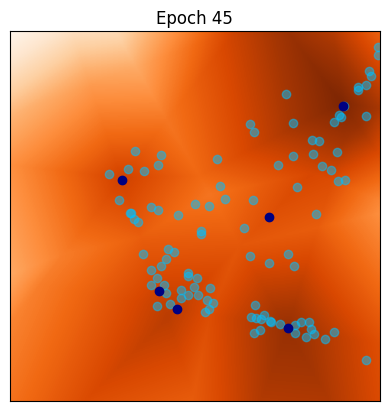

[46/100] 	Loss_D: -0.0660	Loss_G: -47.5494	Lip(D)=1.2827
[47/100] 	Loss_D: -0.0654	Loss_G: -49.1449	Lip(D)=1.3326
[48/100] 	Loss_D: -0.0985	Loss_G: -47.0207	Lip(D)=1.2496
[49/100] 	Loss_D: -0.1140	Loss_G: -48.2820	Lip(D)=1.2536
[50/100] 	Loss_D: -0.1095	Loss_G: -44.4470	Lip(D)=1.3158


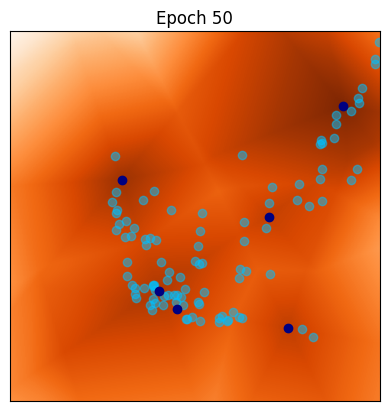

[51/100] 	Loss_D: -0.0967	Loss_G: -47.6954	Lip(D)=1.2256
[52/100] 	Loss_D: -0.0645	Loss_G: -47.8555	Lip(D)=1.3568
[53/100] 	Loss_D: -0.1098	Loss_G: -50.1011	Lip(D)=1.4009
[54/100] 	Loss_D: -0.1150	Loss_G: -49.5073	Lip(D)=1.1480
[55/100] 	Loss_D: -0.1114	Loss_G: -53.0713	Lip(D)=1.6374


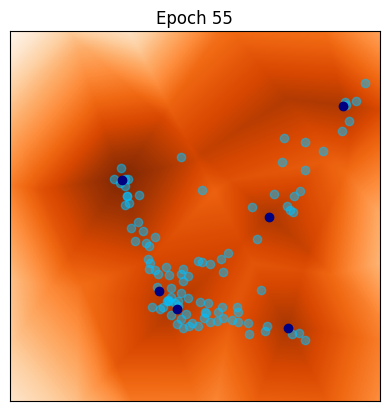

[56/100] 	Loss_D: -0.1028	Loss_G: -50.6394	Lip(D)=1.2256
[57/100] 	Loss_D: -0.0843	Loss_G: -48.9191	Lip(D)=1.3493
[58/100] 	Loss_D: -0.0913	Loss_G: -52.7697	Lip(D)=1.2911
[59/100] 	Loss_D: -0.0879	Loss_G: -52.1345	Lip(D)=1.7001
[60/100] 	Loss_D: -0.0916	Loss_G: -50.1874	Lip(D)=1.4669


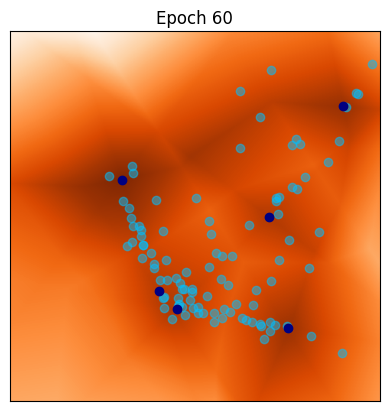

[61/100] 	Loss_D: -0.1034	Loss_G: -49.0685	Lip(D)=1.4078
[62/100] 	Loss_D: -0.0964	Loss_G: -45.5488	Lip(D)=1.2141
[63/100] 	Loss_D: -0.0873	Loss_G: -46.7684	Lip(D)=1.5580
[64/100] 	Loss_D: -0.1060	Loss_G: -55.2067	Lip(D)=1.3004
[65/100] 	Loss_D: -0.0287	Loss_G: -54.0401	Lip(D)=1.2133


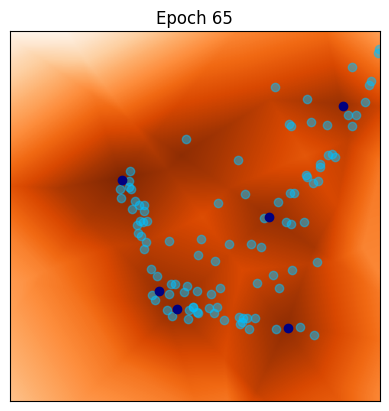

[66/100] 	Loss_D: -0.0760	Loss_G: -49.2083	Lip(D)=1.2568
[67/100] 	Loss_D: -0.1177	Loss_G: -46.2646	Lip(D)=1.5214
[68/100] 	Loss_D: -0.1115	Loss_G: -50.2240	Lip(D)=1.5575
[69/100] 	Loss_D: -0.0645	Loss_G: -55.4913	Lip(D)=1.4581
[70/100] 	Loss_D: -0.0949	Loss_G: -55.3956	Lip(D)=1.3686


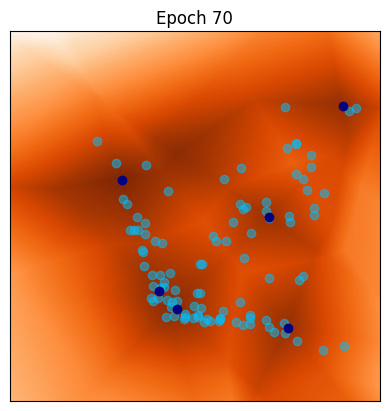

[71/100] 	Loss_D: -0.0974	Loss_G: -49.2896	Lip(D)=1.3712
[72/100] 	Loss_D: -0.0951	Loss_G: -52.8215	Lip(D)=1.5016
[73/100] 	Loss_D: -0.1068	Loss_G: -61.0274	Lip(D)=1.4222
[74/100] 	Loss_D: -0.1000	Loss_G: -62.0762	Lip(D)=1.2820
[75/100] 	Loss_D: -0.1024	Loss_G: -66.7031	Lip(D)=1.2590


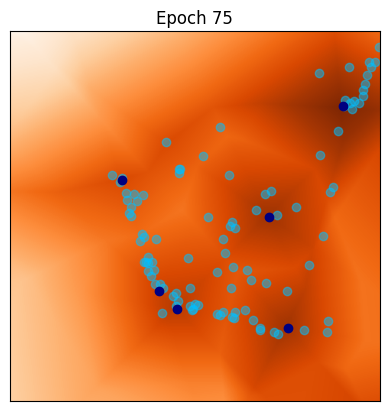

[76/100] 	Loss_D: -0.1085	Loss_G: -72.1898	Lip(D)=1.4513
[77/100] 	Loss_D: -0.0673	Loss_G: -73.2345	Lip(D)=1.1028
[78/100] 	Loss_D: -0.1022	Loss_G: -69.6901	Lip(D)=1.3358
[79/100] 	Loss_D: -0.0654	Loss_G: -72.7517	Lip(D)=1.3897
[80/100] 	Loss_D: -0.0615	Loss_G: -75.2479	Lip(D)=1.3499


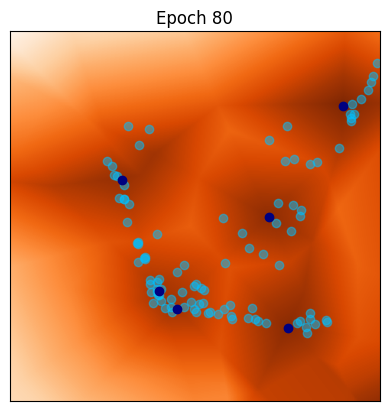

[81/100] 	Loss_D: -0.1070	Loss_G: -77.3292	Lip(D)=1.5185
[82/100] 	Loss_D: -0.0857	Loss_G: -80.9229	Lip(D)=1.6581
[83/100] 	Loss_D: -0.1035	Loss_G: -82.9639	Lip(D)=1.3458
[84/100] 	Loss_D: -0.0928	Loss_G: -82.2225	Lip(D)=1.3484
[85/100] 	Loss_D: -0.0994	Loss_G: -82.5965	Lip(D)=1.5513


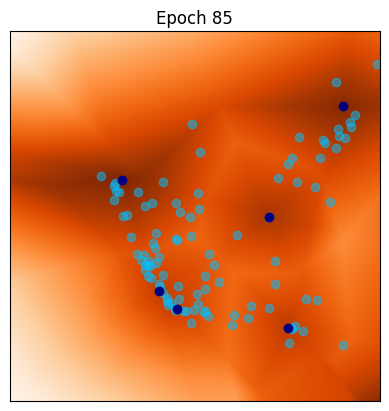

[86/100] 	Loss_D: -0.0732	Loss_G: -86.1927	Lip(D)=1.4820
[87/100] 	Loss_D: -0.1165	Loss_G: -82.6757	Lip(D)=1.3613
[88/100] 	Loss_D: -0.0889	Loss_G: -82.4179	Lip(D)=1.2858
[89/100] 	Loss_D: -0.0934	Loss_G: -87.9041	Lip(D)=1.3272
[90/100] 	Loss_D: -0.0949	Loss_G: -85.7506	Lip(D)=1.2344


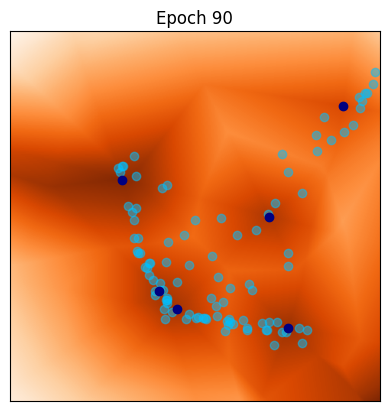

[91/100] 	Loss_D: -0.0842	Loss_G: -82.4718	Lip(D)=1.3439
[92/100] 	Loss_D: -0.0890	Loss_G: -80.2990	Lip(D)=1.4248
[93/100] 	Loss_D: -0.1014	Loss_G: -88.3231	Lip(D)=1.3606
[94/100] 	Loss_D: -0.1083	Loss_G: -90.8328	Lip(D)=1.3240
[95/100] 	Loss_D: -0.1141	Loss_G: -84.5787	Lip(D)=1.4245


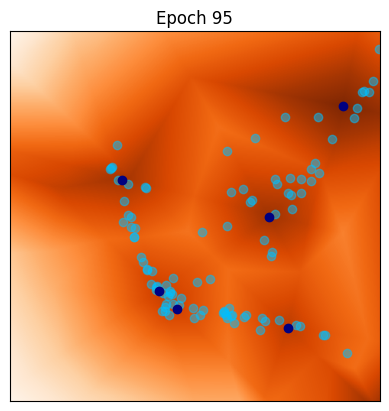

[96/100] 	Loss_D: -0.1139	Loss_G: -85.8704	Lip(D)=1.3231
[97/100] 	Loss_D: -0.1031	Loss_G: -86.7063	Lip(D)=1.3935
[98/100] 	Loss_D: -0.0982	Loss_G: -88.3791	Lip(D)=1.3694
[99/100] 	Loss_D: -0.0883	Loss_G: -86.6643	Lip(D)=1.1140


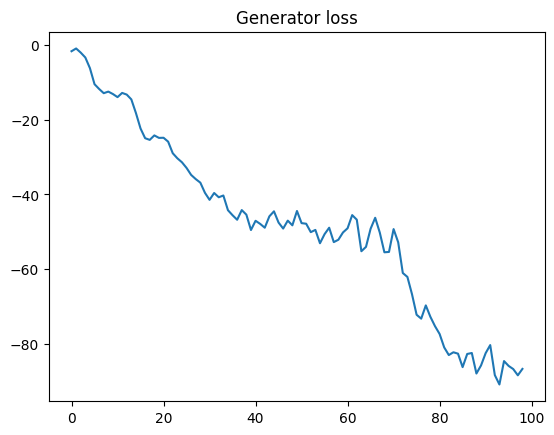

<All keys matched successfully>

In [11]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        y_real = y

        D_real = D(y_real).view(-1)
        D_fake = D(x_fake.detach()).view(-1)

        gp = gradient_penalty(D, y_real, x_fake)
        Dloss = -torch.mean(D_real) + torch.mean(D_fake) + gpw * gp

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = -torch.mean(D(x_fake))

        Gloss.backward()
        optimG.step()
    lip_const = lipconstant(D, y, G(torch.randn(b, n_in, device=device)))

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lip_const.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

**Answer** :
For stable GAN training, use lower learning rates for the generator than the discriminator, and properly tune the gradient penalty weight. Balance the number of updates between the discriminator and generator, and regularly monitor the losses and Lipschitz constant.

[1/30] 	Loss_D: -0.1256	Loss_G: -1.4483	Lip(D)=0.9921
[2/30] 	Loss_D: -0.1037	Loss_G: -2.4913	Lip(D)=1.0012
[3/30] 	Loss_D: -0.0915	Loss_G: -3.5599	Lip(D)=1.0020
[4/30] 	Loss_D: -0.0885	Loss_G: -4.6555	Lip(D)=1.0020
[5/30] 	Loss_D: -0.0822	Loss_G: -5.7596	Lip(D)=0.9999


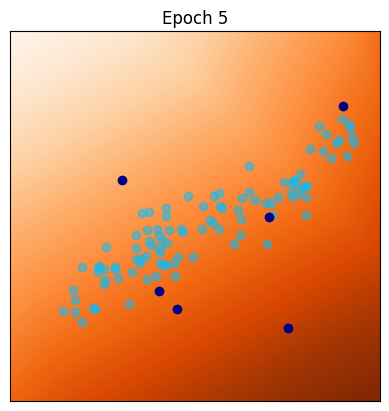

[6/30] 	Loss_D: -0.0921	Loss_G: -6.8380	Lip(D)=0.9999
[7/30] 	Loss_D: -0.0891	Loss_G: -7.6410	Lip(D)=1.0025
[8/30] 	Loss_D: -0.0952	Loss_G: -8.2205	Lip(D)=0.9971
[9/30] 	Loss_D: -0.0700	Loss_G: -8.8487	Lip(D)=0.9976
[10/30] 	Loss_D: 0.0265	Loss_G: -9.8081	Lip(D)=1.0239


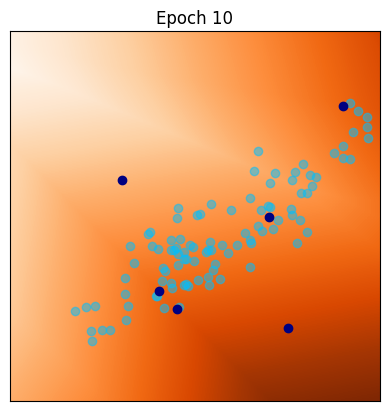

[11/30] 	Loss_D: -0.0733	Loss_G: -10.4236	Lip(D)=1.0077
[12/30] 	Loss_D: -0.0757	Loss_G: -11.1249	Lip(D)=1.0008
[13/30] 	Loss_D: -0.0611	Loss_G: -11.9353	Lip(D)=1.0009
[14/30] 	Loss_D: -0.0574	Loss_G: -12.7183	Lip(D)=0.9991
[15/30] 	Loss_D: -0.0358	Loss_G: -13.4827	Lip(D)=0.9970


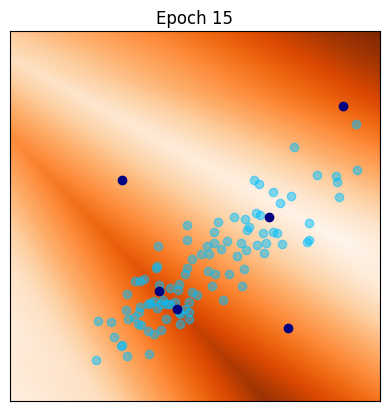

[16/30] 	Loss_D: -0.1139	Loss_G: -14.8350	Lip(D)=0.9995
[17/30] 	Loss_D: -0.0951	Loss_G: -16.7591	Lip(D)=0.9975
[18/30] 	Loss_D: -0.0740	Loss_G: -19.0092	Lip(D)=1.0046
[19/30] 	Loss_D: -0.0249	Loss_G: -22.0447	Lip(D)=0.9907
[20/30] 	Loss_D: -0.0673	Loss_G: -25.1873	Lip(D)=1.0009


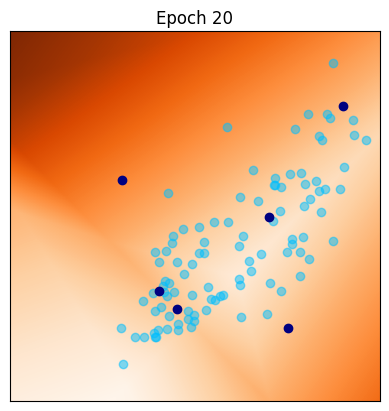

[21/30] 	Loss_D: -0.0881	Loss_G: -27.4602	Lip(D)=1.0072
[22/30] 	Loss_D: -0.0639	Loss_G: -28.8754	Lip(D)=1.0102
[23/30] 	Loss_D: -0.0489	Loss_G: -26.2100	Lip(D)=0.9996
[24/30] 	Loss_D: -0.0544	Loss_G: -27.6359	Lip(D)=0.9969
[25/30] 	Loss_D: -0.0239	Loss_G: -28.9156	Lip(D)=1.0206


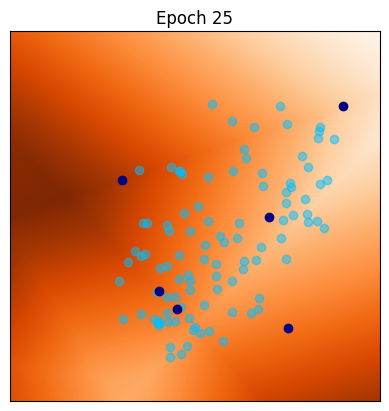

[26/30] 	Loss_D: -0.0322	Loss_G: -30.7465	Lip(D)=1.0177
[27/30] 	Loss_D: -0.0497	Loss_G: -33.0867	Lip(D)=1.0028
[28/30] 	Loss_D: -0.0423	Loss_G: -30.5987	Lip(D)=1.0046
[29/30] 	Loss_D: -0.0519	Loss_G: -30.4823	Lip(D)=0.9978


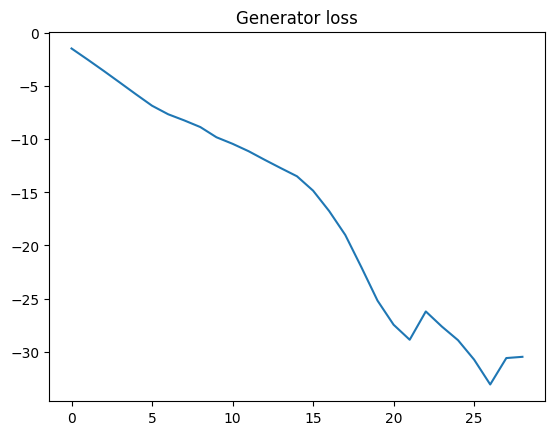

<All keys matched successfully>

In [12]:
## parameters for training
n_epochs = 30
niterD=1000
niterG=10
gpw = 30

lr = 0.0004      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        y_real = y

        D_real = D(y_real).view(-1)
        D_fake = D(x_fake.detach()).view(-1)

        gp = gradient_penalty(D, y_real, x_fake)
        Dloss = -torch.mean(D_real) + torch.mean(D_fake) + gpw * gp

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = -torch.mean(D(x_fake))

        Gloss.backward()
        optimG.step()
    lip_const = lipconstant(D, y, G(torch.randn(b, n_in, device=device)))

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lip_const.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

**Answer**:
When optimizing only the generator with a fixed discriminator, the generator improves to fool the static discriminator, but may overfit to the discriminator's specific weaknesses, leading to less generalizable results. This process lacks dynamic feedback, which typically stabilizes GAN training.

[1/100] 	Loss_G: -0.0698
[2/100] 	Loss_G: -0.0760
[3/100] 	Loss_G: -0.0822
[4/100] 	Loss_G: -0.0914
[5/100] 	Loss_G: -0.1019


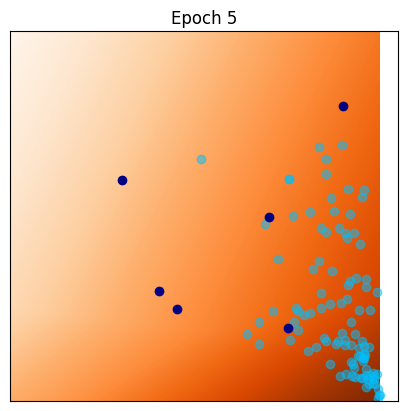

[6/100] 	Loss_G: -0.1119
[7/100] 	Loss_G: -0.1204
[8/100] 	Loss_G: -0.1252
[9/100] 	Loss_G: -0.1278
[10/100] 	Loss_G: -0.1299


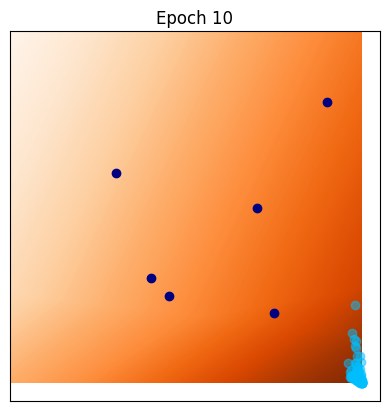

[11/100] 	Loss_G: -0.1305
[12/100] 	Loss_G: -0.1310
[13/100] 	Loss_G: -0.1316
[14/100] 	Loss_G: -0.1318
[15/100] 	Loss_G: -0.1319


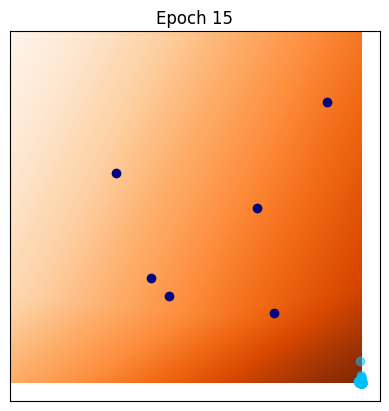

[16/100] 	Loss_G: -0.1321
[17/100] 	Loss_G: -0.1322
[18/100] 	Loss_G: -0.1322
[19/100] 	Loss_G: -0.1323
[20/100] 	Loss_G: -0.1323


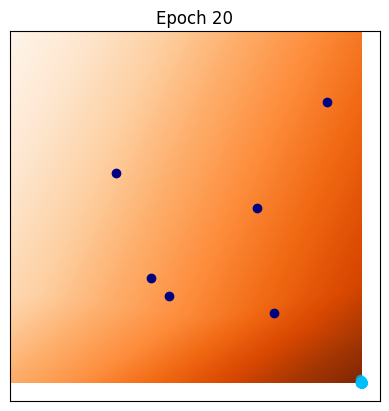

[21/100] 	Loss_G: -0.1324
[22/100] 	Loss_G: -0.1324
[23/100] 	Loss_G: -0.1324
[24/100] 	Loss_G: -0.1325
[25/100] 	Loss_G: -0.1325


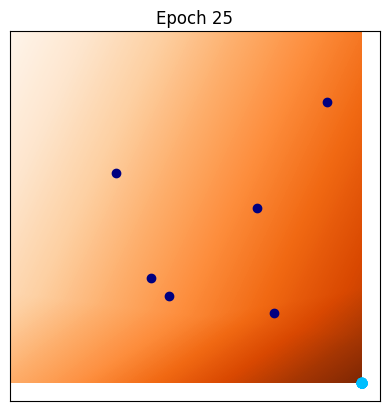

[26/100] 	Loss_G: -0.1325
[27/100] 	Loss_G: -0.1326
[28/100] 	Loss_G: -0.1326
[29/100] 	Loss_G: -0.1326
[30/100] 	Loss_G: -0.1326


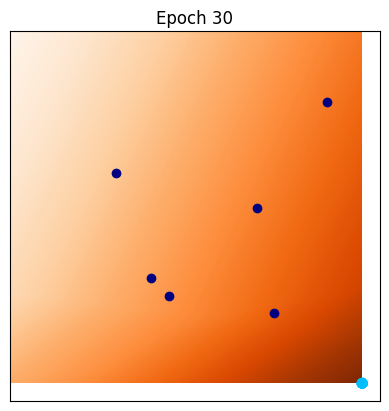

[31/100] 	Loss_G: -0.1326
[32/100] 	Loss_G: -0.1326
[33/100] 	Loss_G: -0.1326
[34/100] 	Loss_G: -0.1326
[35/100] 	Loss_G: -0.1326


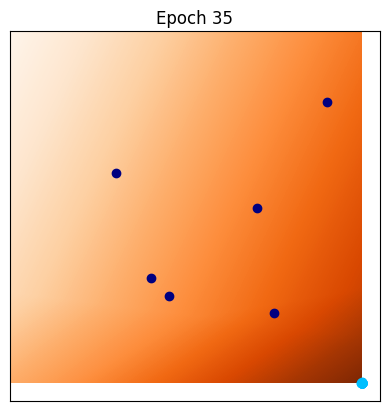

[36/100] 	Loss_G: -0.1326
[37/100] 	Loss_G: -0.1326
[38/100] 	Loss_G: -0.1326
[39/100] 	Loss_G: -0.1326
[40/100] 	Loss_G: -0.1327


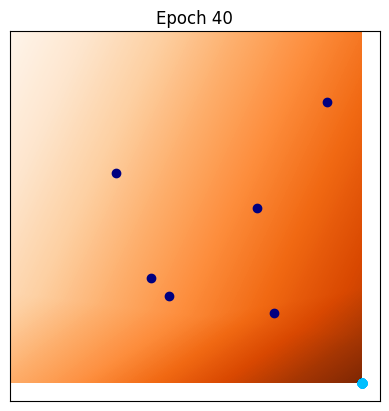

[41/100] 	Loss_G: -0.1326
[42/100] 	Loss_G: -0.1326
[43/100] 	Loss_G: -0.1327
[44/100] 	Loss_G: -0.1327
[45/100] 	Loss_G: -0.1327


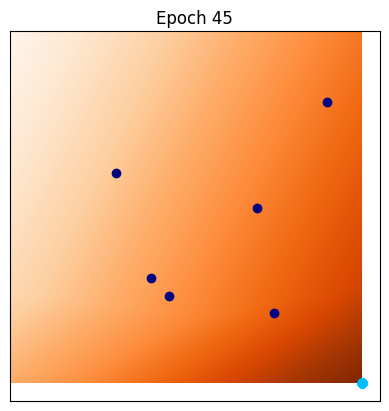

[46/100] 	Loss_G: -0.1327
[47/100] 	Loss_G: -0.1327
[48/100] 	Loss_G: -0.1327
[49/100] 	Loss_G: -0.1327
[50/100] 	Loss_G: -0.1327


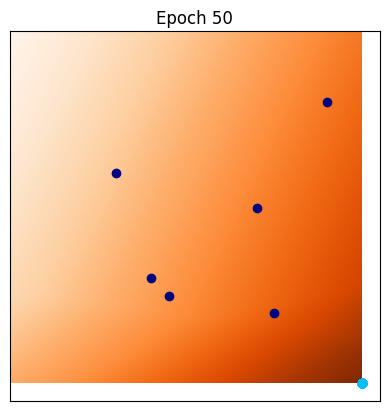

[51/100] 	Loss_G: -0.1327
[52/100] 	Loss_G: -0.1327
[53/100] 	Loss_G: -0.1327
[54/100] 	Loss_G: -0.1327
[55/100] 	Loss_G: -0.1327


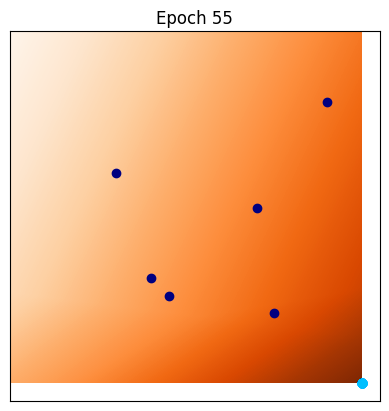

[56/100] 	Loss_G: -0.1327
[57/100] 	Loss_G: -0.1327
[58/100] 	Loss_G: -0.1327
[59/100] 	Loss_G: -0.1327
[60/100] 	Loss_G: -0.1327


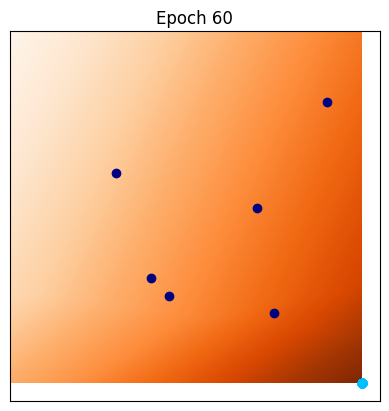

[61/100] 	Loss_G: -0.1327
[62/100] 	Loss_G: -0.1327
[63/100] 	Loss_G: -0.1327
[64/100] 	Loss_G: -0.1327
[65/100] 	Loss_G: -0.1327


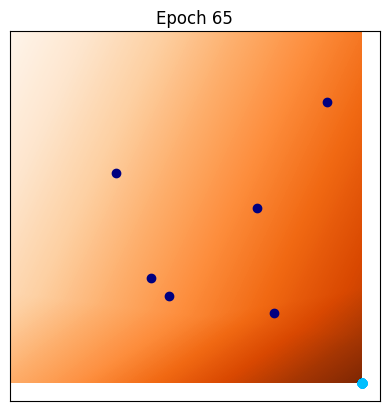

[66/100] 	Loss_G: -0.1327
[67/100] 	Loss_G: -0.1327
[68/100] 	Loss_G: -0.1327
[69/100] 	Loss_G: -0.1327
[70/100] 	Loss_G: -0.1327


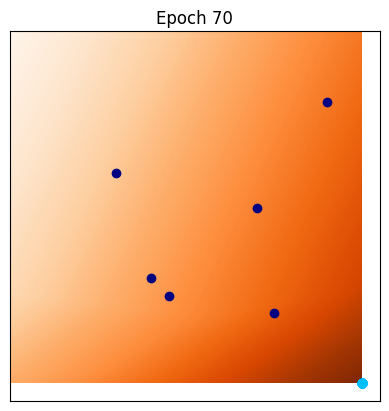

[71/100] 	Loss_G: -0.1327
[72/100] 	Loss_G: -0.1327
[73/100] 	Loss_G: -0.1327
[74/100] 	Loss_G: -0.1327
[75/100] 	Loss_G: -0.1327


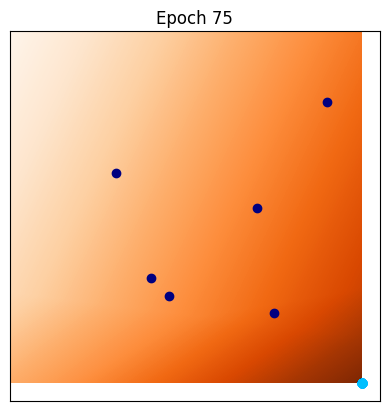

[76/100] 	Loss_G: -0.1327
[77/100] 	Loss_G: -0.1327
[78/100] 	Loss_G: -0.1327
[79/100] 	Loss_G: -0.1327
[80/100] 	Loss_G: -0.1327


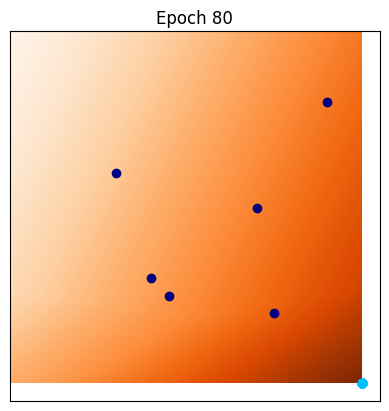

[81/100] 	Loss_G: -0.1327
[82/100] 	Loss_G: -0.1327
[83/100] 	Loss_G: -0.1327
[84/100] 	Loss_G: -0.1327
[85/100] 	Loss_G: -0.1327


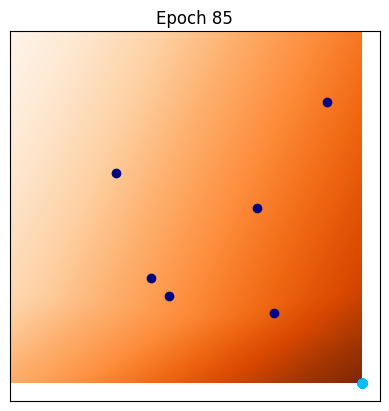

[86/100] 	Loss_G: -0.1327
[87/100] 	Loss_G: -0.1327
[88/100] 	Loss_G: -0.1327
[89/100] 	Loss_G: -0.1327
[90/100] 	Loss_G: -0.1327


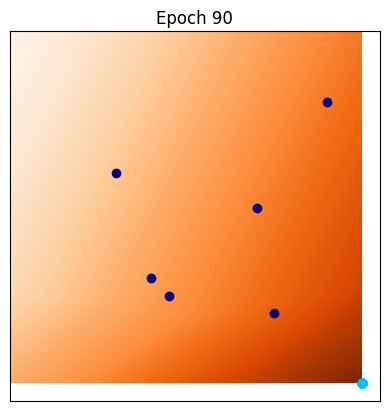

[91/100] 	Loss_G: -0.1327
[92/100] 	Loss_G: -0.1327
[93/100] 	Loss_G: -0.1327
[94/100] 	Loss_G: -0.1327
[95/100] 	Loss_G: -0.1327


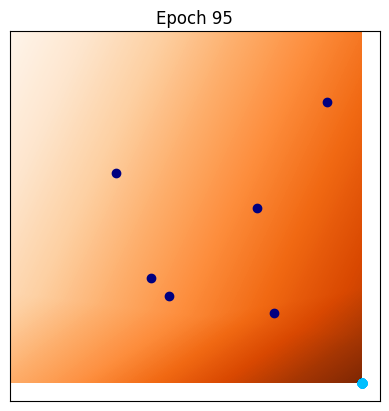

[96/100] 	Loss_G: -0.1327
[97/100] 	Loss_G: -0.1327
[98/100] 	Loss_G: -0.1327
[99/100] 	Loss_G: -0.1327
[100/100] 	Loss_G: -0.1327


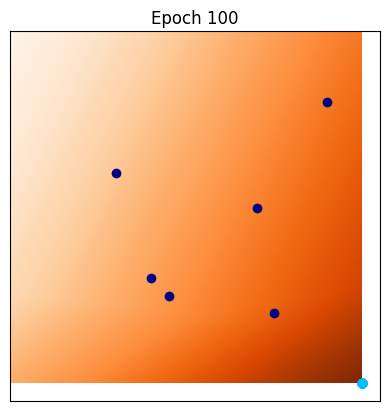

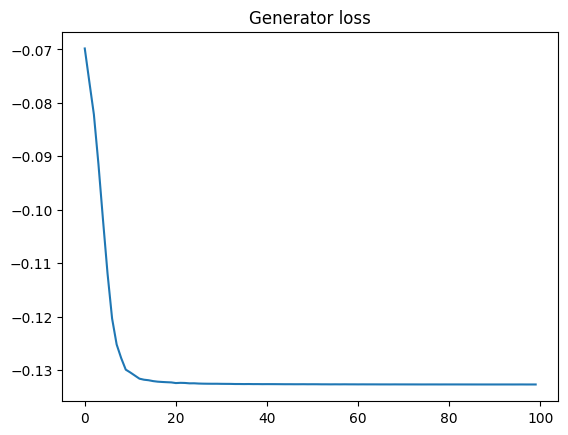

<All keys matched successfully>

In [13]:
# Parameters for training
n_epochs = 100
niterG = 10
gpw = .1

lr = 0.002
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)

G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

D = Discriminator(n_in=d, n_hid=10).to(device)


Glosses = []

iter_display = 5

# Main loop
for epoch in range(1, n_epochs + 1):

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = -torch.mean(D(x_fake))

        Gloss.backward()
        optimG.step()

    print('[%d/%d] \tLoss_G: %.4f'
          % (epoch, n_epochs, Gloss.item()))
    Glosses.append(Gloss.item())

    if epoch % iter_display == 0:
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch ' + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())


<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [14]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.383946


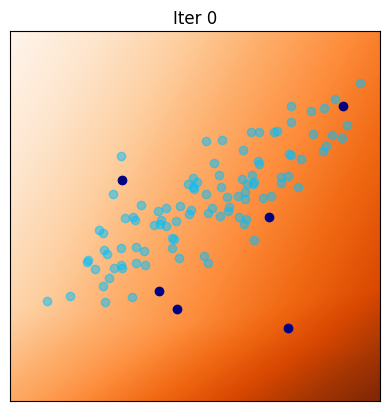

[100/1000], 1.208848


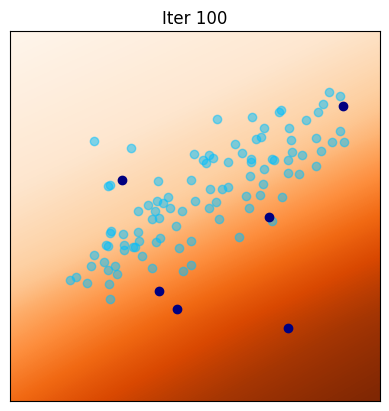

[200/1000], 1.064496


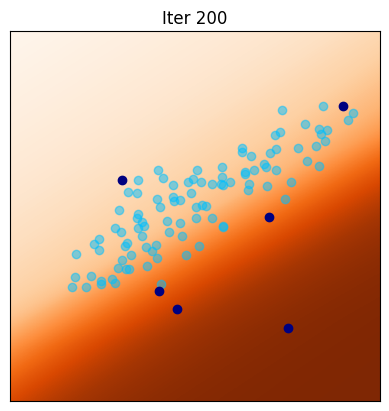

[300/1000], 1.016988


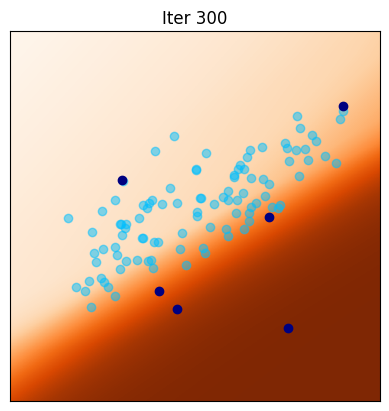

[400/1000], 0.907898


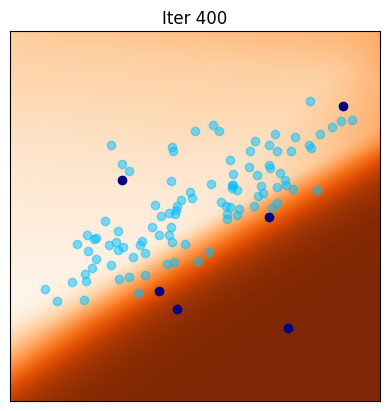

[500/1000], 0.870148


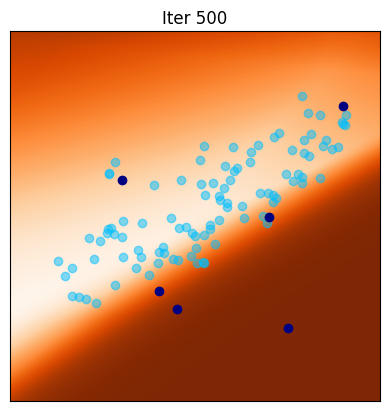

[600/1000], 0.690487


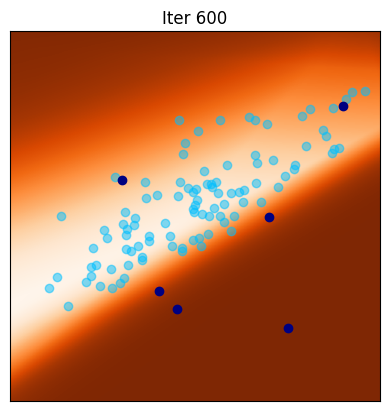

[700/1000], 0.660583


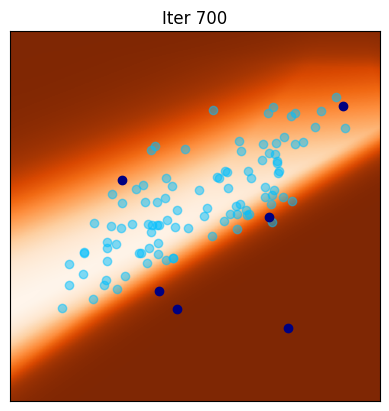

[800/1000], 0.548540


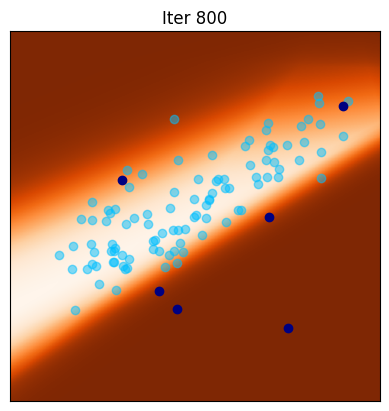

[900/1000], 0.550668


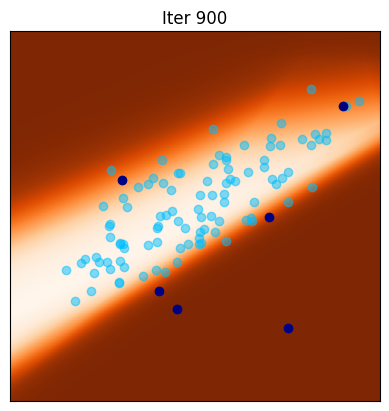

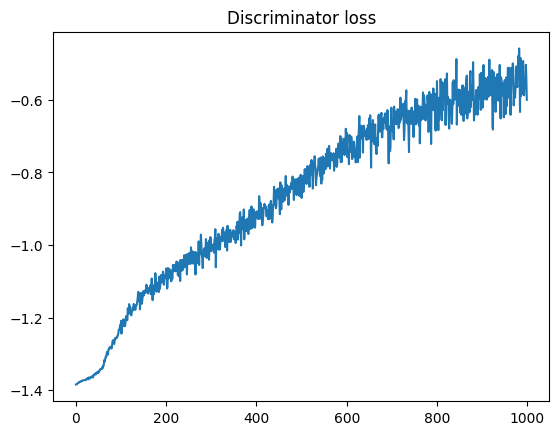

In [15]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x_fake = G(z)

    y_real = y

    D_real = D(y_real)
    D_fake = D(x_fake.detach())

    Dloss_real = criterion(D_real, V1)
    Dloss_fake = criterion(D_fake, V0)
    Dloss = Dloss_real + Dloss_fake

    Dloss.backward()
    optimD.step()


    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.2335	Loss_G: 0.8061


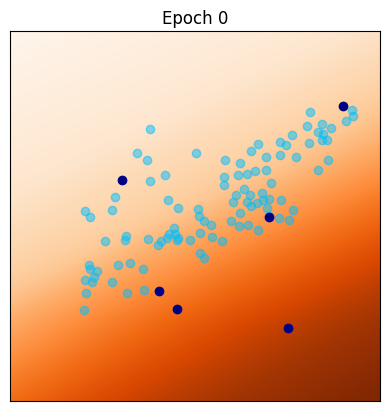

[1/100] 	Loss_D: 1.0810	Loss_G: 0.9202
[2/100] 	Loss_D: 1.0182	Loss_G: 1.0080
[3/100] 	Loss_D: 0.9553	Loss_G: 1.1172
[4/100] 	Loss_D: 0.9102	Loss_G: 1.2342
[5/100] 	Loss_D: 0.8547	Loss_G: 1.4608
[6/100] 	Loss_D: 0.7619	Loss_G: 1.4250
[7/100] 	Loss_D: 0.7863	Loss_G: 1.7120
[8/100] 	Loss_D: 0.8451	Loss_G: 1.6432
[9/100] 	Loss_D: 0.8324	Loss_G: 1.6112
[10/100] 	Loss_D: 0.8401	Loss_G: 1.3920


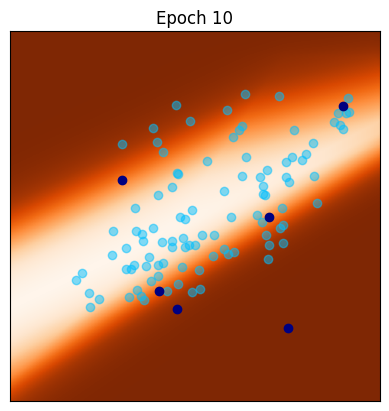

[11/100] 	Loss_D: 0.9652	Loss_G: 1.6411
[12/100] 	Loss_D: 1.0028	Loss_G: 1.3802
[13/100] 	Loss_D: 1.0215	Loss_G: 1.4168
[14/100] 	Loss_D: 1.0989	Loss_G: 1.2867
[15/100] 	Loss_D: 1.1671	Loss_G: 1.1954
[16/100] 	Loss_D: 1.0965	Loss_G: 1.0414
[17/100] 	Loss_D: 1.0839	Loss_G: 1.0865
[18/100] 	Loss_D: 1.1614	Loss_G: 1.1402
[19/100] 	Loss_D: 1.0528	Loss_G: 1.0790
[20/100] 	Loss_D: 1.0552	Loss_G: 0.9908


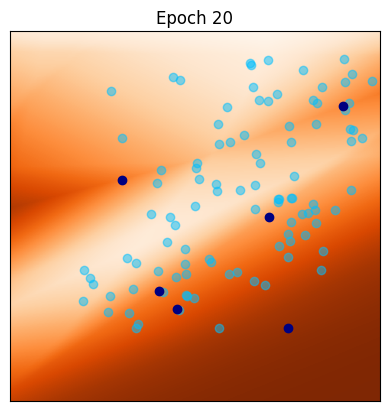

[21/100] 	Loss_D: 1.0435	Loss_G: 1.0995
[22/100] 	Loss_D: 1.0294	Loss_G: 1.0926
[23/100] 	Loss_D: 1.0857	Loss_G: 1.1498
[24/100] 	Loss_D: 1.0334	Loss_G: 1.2132
[25/100] 	Loss_D: 0.9864	Loss_G: 0.9943
[26/100] 	Loss_D: 1.0092	Loss_G: 1.2984
[27/100] 	Loss_D: 0.9142	Loss_G: 1.2385
[28/100] 	Loss_D: 1.0247	Loss_G: 1.3390
[29/100] 	Loss_D: 0.9932	Loss_G: 1.3539
[30/100] 	Loss_D: 1.0015	Loss_G: 1.5026


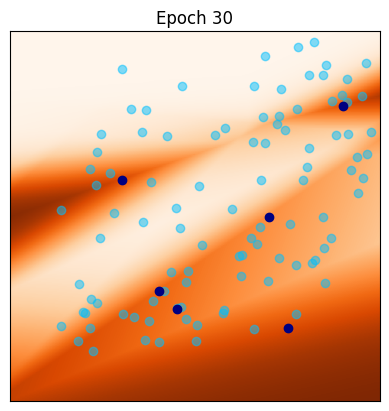

[31/100] 	Loss_D: 0.9417	Loss_G: 1.2240
[32/100] 	Loss_D: 0.9664	Loss_G: 1.8634
[33/100] 	Loss_D: 0.9260	Loss_G: 1.5736
[34/100] 	Loss_D: 0.8700	Loss_G: 1.2802
[35/100] 	Loss_D: 0.9013	Loss_G: 1.6489
[36/100] 	Loss_D: 0.8452	Loss_G: 1.4906
[37/100] 	Loss_D: 0.9523	Loss_G: 1.6416
[38/100] 	Loss_D: 0.8872	Loss_G: 1.4627
[39/100] 	Loss_D: 0.8069	Loss_G: 1.6032
[40/100] 	Loss_D: 0.8658	Loss_G: 1.8832


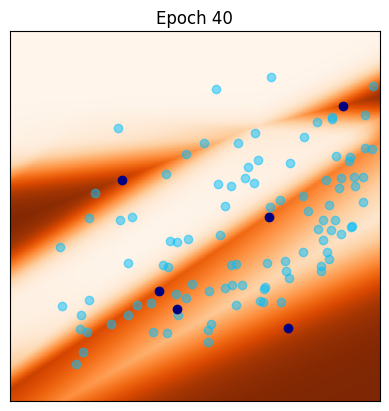

[41/100] 	Loss_D: 0.8760	Loss_G: 1.5544
[42/100] 	Loss_D: 0.8926	Loss_G: 1.5520
[43/100] 	Loss_D: 0.7453	Loss_G: 1.4655
[44/100] 	Loss_D: 0.7969	Loss_G: 1.6022
[45/100] 	Loss_D: 0.8703	Loss_G: 1.6846
[46/100] 	Loss_D: 0.8645	Loss_G: 1.9024
[47/100] 	Loss_D: 0.7855	Loss_G: 1.6318
[48/100] 	Loss_D: 0.8089	Loss_G: 1.8455
[49/100] 	Loss_D: 0.8687	Loss_G: 1.9619
[50/100] 	Loss_D: 0.8622	Loss_G: 1.7259


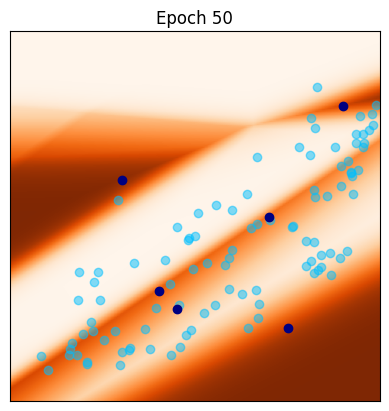

[51/100] 	Loss_D: 0.8260	Loss_G: 1.4758
[52/100] 	Loss_D: 0.7694	Loss_G: 1.2897
[53/100] 	Loss_D: 0.8633	Loss_G: 1.7079
[54/100] 	Loss_D: 0.9358	Loss_G: 1.9107
[55/100] 	Loss_D: 0.8493	Loss_G: 1.6283
[56/100] 	Loss_D: 0.8219	Loss_G: 1.5757
[57/100] 	Loss_D: 0.7703	Loss_G: 1.7549
[58/100] 	Loss_D: 0.7910	Loss_G: 1.4788
[59/100] 	Loss_D: 0.8414	Loss_G: 1.5893
[60/100] 	Loss_D: 0.7698	Loss_G: 1.4449


In [ ]:
lr = 0.002
lrdisc = 0.002

n_epochs = 100
niterD = 100
niterG = 1

torch.manual_seed(1)

G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

V1 = torch.full((b, 1), 1.0, dtype=torch.float, device=device)
V0 = torch.full((b, 1), 0.0, dtype=torch.float, device=device)

Glosses = []
Dlosses = []

iter_display = 10

for epoch in range(n_epochs):


    for iter in range(niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        y_real = y

        V1_real = torch.full((y_real.size(0), 1), 1.0, dtype=torch.float, device=device)

        D_real = D(y_real)
        D_fake = D(x_fake.detach())

        Dloss_real = criterion(D_real, V1_real)
        Dloss_fake = criterion(D_fake, V0)
        Dloss = Dloss_real + Dloss_fake

        Dloss.backward()
        optimD.step()

    for iter in range(niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = criterion(D(x_fake), V1)

        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if epoch % iter_display == 0:
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch ' + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()


generator and discriminator are well trained.